In [2]:
import sqlite3
import pandas as pd
import numpy as np
from contextlib import contextmanager
import numpy as np

@contextmanager
def sqlite_connection(db_name: str):
    conn = sqlite3.connect(db_name)
    sqlite3.register_adapter(np.int64, lambda val: int(val))
    sqlite3.register_adapter(np.float64, lambda val: float(val))
    sqlite3.register_adapter(np.float32, lambda val: float(val))
    try:
        yield conn
    finally:
        conn.close()

# Create a connection to the database
SQLITE_PATH = './fits.db'

def get_df(query: str) -> pd.DataFrame:
    with sqlite_connection(SQLITE_PATH) as conn:
        return pd.read_sql_query(query, conn, dtype={'timestamp': 'datetime64[ns]'})

# Execute a query
# Querying data
query = """
select fits.timestamp, fits.flux
from fits
join metadata on fits.metadata_rowid = metadata.rowid
where metadata.rowid = 4
"""
result = get_df(query)

result.head()

,timestamp,flux
0,2012-01-04 00:00:00,4.209151e-07
1,2012-01-04 00:01:00,4.283863e-07
2,2012-01-04 00:02:00,4.280558e-07
3,2012-01-04 00:03:00,4.195552e-07
4,2012-01-04 00:04:00,4.201690e-07


In [3]:
query = """
    select timestamp, flux
    from fits
    where flux >= 0
    """

df = get_df(query)
df.count()

timestamp    43186
flux         43186
dtype: int64

In [4]:
filtered_df = df.copy()
filtered_df.set_index('timestamp', inplace=True)
filtered_df.sort_index(inplace=True)
subset = filtered_df.loc['2017-01-01':'2017-12-31']

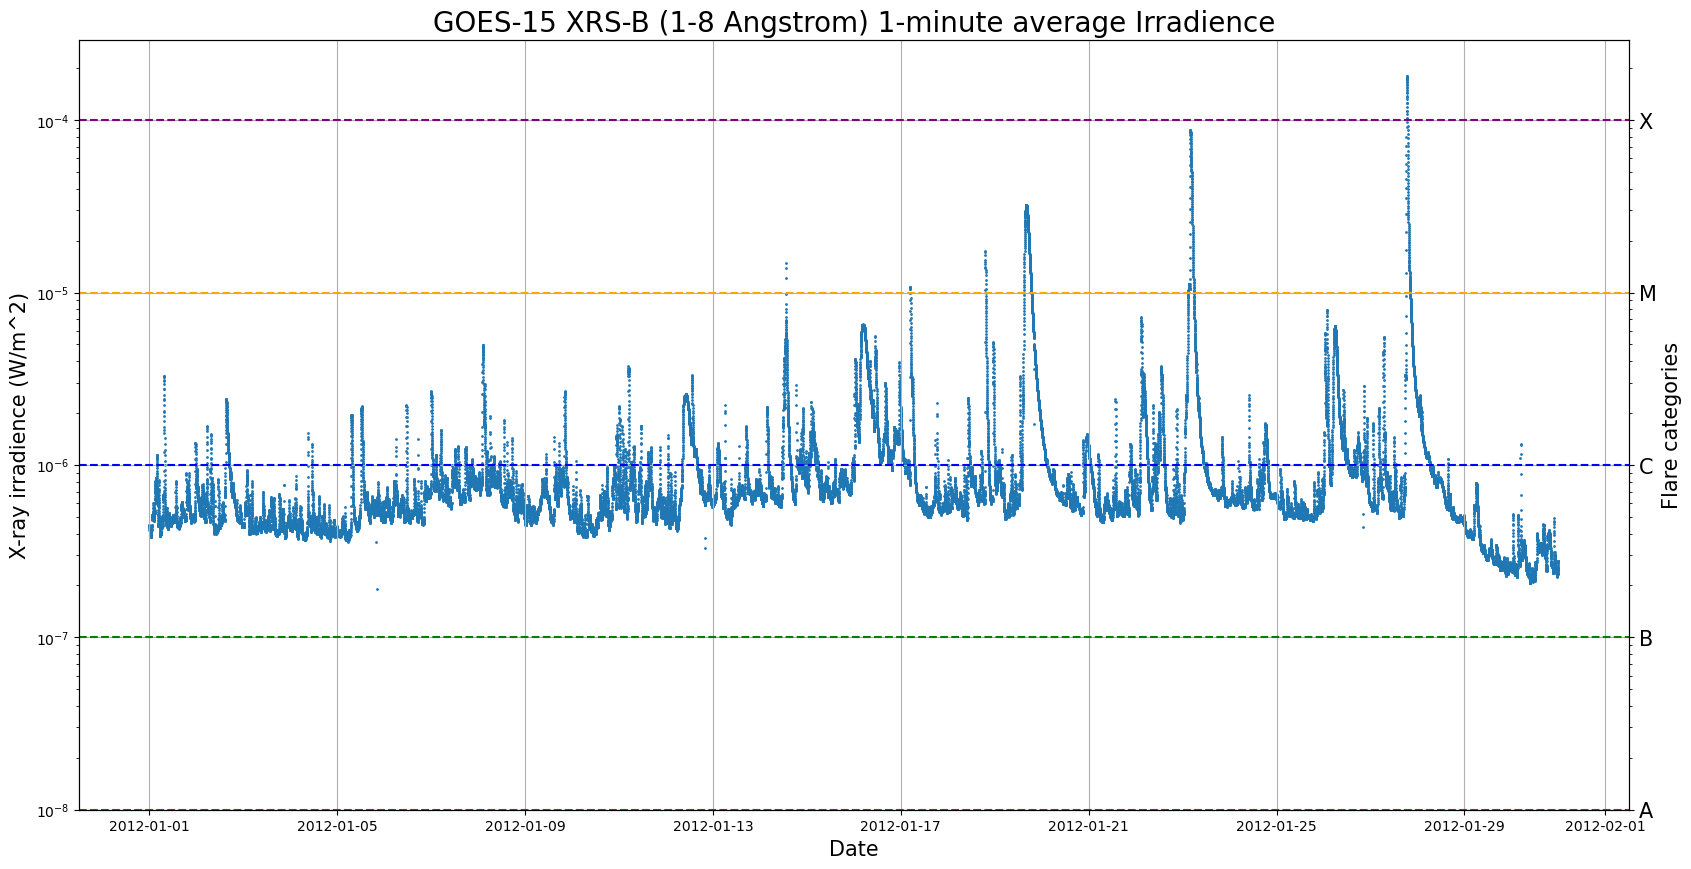

In [5]:
from re import sub
from tkinter import font
from matplotlib import pyplot as plt
from datetime import datetime

def plot_flux(df: pd.DataFrame):
    SMALL_SIZE = 8
    MEDIUM_SIZE = 15
    BIGGER_SIZE = 20

    fig, ax1 = plt.subplots(figsize=(20, 10))
    ax2 = ax1.twinx()

    ax1.scatter(df.index, df['flux'], label='flux', s=1)

    colors = {
        'A': 'red',
        'B': 'green',
        'C': 'blue',
        'M': 'orange',
        'X': 'purple'
    }

    thresholds = [(1e-8, 'A'), (1e-7, 'B'), (1e-6, 'C'), (1e-5, 'M'), (1e-4, 'X')]
    for t in thresholds:
        ax1.axhline(y=t[0], color=colors[t[1]], linestyle='--', label=f'Threshold {t[1]}')

    # Set y-axis to log scale
    ax1.set_yscale('log')
    ax1.set_ylim(1e-8)
    # plt.xlim(datetime(year=2014, month=1, day=1), datetime(year=2017, month=12, day=31))

    ax2.set_yscale('log')
    ax2.set_ylim(*ax1.get_ylim())
    ax2.set_ylabel('Flare categories', fontsize=MEDIUM_SIZE)
    ax2.set_yticks([t[0] for t in thresholds])
    ax2.set_yticklabels([t[1] for t in thresholds], fontsize=MEDIUM_SIZE)

    ax1.set_xlabel('Date', fontsize=MEDIUM_SIZE)
    ax1.set_ylabel('X-ray irradience (W/m^2)', fontsize=MEDIUM_SIZE)
    ax1.set_title('GOES-15 XRS-B (1-8 Angstrom) 1-minute average Irradience', fontsize=BIGGER_SIZE)

    ax1.grid(True)
    # plt.grid(True)

    SMALL_SIZE = 8
    MEDIUM_SIZE = 10
    BIGGER_SIZE = 12

    plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

    plt.show()


plot_flux(filtered_df)

# TODO

See: https://www.ngdc.noaa.gov/stp/solar/solarflares.html

GOES x-ray events: The event starts when 4 consecutive 1-minute Xray values have met all three of the following conditions -- a.) All 4 values are above the B1 threshold and b.) All 4 values are strictly increasing and c.) The last value is greater than 1.4 times the value which occurred 3 minutes earlier. The maximum is the time when the flux value reaches maximum. The maximum flux value (the event size) is the flux, as defined by the C-M-X scale, at the time of maximum. The event ends when the current flux reading returns to 1/2 the 'peak' (peak is the sum of the flux at maximum plus the flux value at the start of the event). 

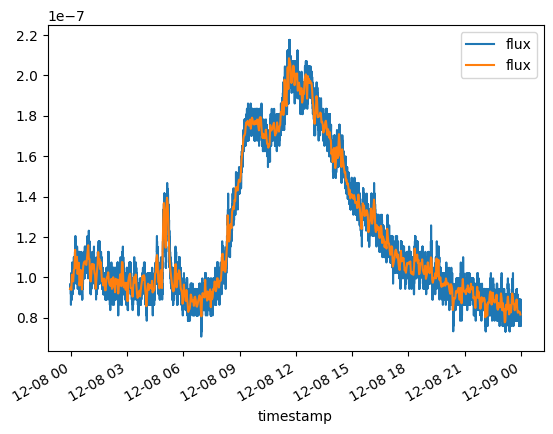

In [15]:
from matplotlib import pyplot as plt

ax = result.plot(x='timestamp', y='flux')
df.plot(ax=ax)
plt.show()

# plt.plot(result.timestamp, result.flux)

In [1]:
from typing import Iterable
from datetime import datetime
from matplotlib import pyplot as plt

def plot_fits_values(values: Iterable[tuple[datetime, float]]) -> None:
    # Extract the timestamps and flux values from the iterable
    timestamps, fluxes = zip(*values)

    # Convert the timestamps to hours since the first timestamp
    timestamps = np.array(timestamps)
    timestamps = (timestamps - timestamps[0]).astype("timedelta64[m]").astype(int) / 60

    # Plot the flux values
    plt.plot(timestamps, fluxes)
    plt.xlabel("Time")
    plt.ylabel("Flux (W/m^2)")
    plt.title("Flux over Time from FITS File")
    plt.show()

In [6]:
_sql = """
WITH RECURSIVE EventStarts AS (
  SELECT 
    timestamp AS start_time,
    flux AS start_flux,
    LEAD(timestamp, 3) OVER (ORDER BY timestamp) AS time_3_min_earlier,
    LAG(flux, 3) OVER (ORDER BY timestamp) AS value_3_min_earlier,
    LAG(flux, 2) OVER (ORDER BY timestamp) AS value_2_min_earlier,
    LAG(flux, 1) OVER (ORDER BY timestamp) AS value_1_min_earlier,
    flux,
    LEAD(flux, 1) OVER (ORDER BY timestamp) AS next_flux,
    LEAD(timestamp, 1) OVER (ORDER BY timestamp) AS next_time
  FROM fits
),
EventMax AS (
  SELECT 
    start_time,
    MAX(flux) AS max_flux
  FROM EventStarts
  GROUP BY start_time
),
EventEnds AS (
  SELECT 
    start_time AS end_time,
    start_flux AS peak,
    start_flux / 2 AS half_peak
  FROM EventStarts
)
SELECT 
  es.start_time AS event_start,
  em.max_flux AS max_flux,
  ee.end_time AS event_end
FROM EventStarts es
JOIN EventMax em ON es.start_time = em.start_time
JOIN EventEnds ee ON es.start_time = ee.end_time
WHERE es.flux > 1e-7 
  AND es.flux > value_1_min_earlier 
  AND es.flux > value_2_min_earlier 
  AND es.flux > value_3_min_earlier 
  AND es.flux > 1.4 * value_3_min_earlier
  AND es.flux < ee.half_peak
  AND es.next_flux < ee.half_peak
  AND es.flux < es.start_flux
  AND es.start_time < ee.end_time
"""

In [10]:
sql1 = """
SELECT 
    timestamp AS start_time,
    flux AS start_flux,
    LEAD(timestamp, 3) OVER (ORDER BY timestamp) AS time_3_min_earlier,
    LAG(flux, 3) OVER (ORDER BY timestamp) AS value_3_min_earlier,
    LAG(flux, 2) OVER (ORDER BY timestamp) AS value_2_min_earlier,
    LAG(flux, 1) OVER (ORDER BY timestamp) AS value_1_min_earlier,
    flux,
    LEAD(flux, 1) OVER (ORDER BY timestamp) AS next_flux,
    LEAD(timestamp, 1) OVER (ORDER BY timestamp) AS next_time
  FROM fits
  WHERE start_time < '2012-01-01'
  """

df = get_df(sql1)

KeyError: "Only a column name can be used for the key in a dtype mappings argument. 'timestamp' not found in columns."